In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


## Sentiment and Reason Analyis on Airplane Tweets

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Flatten,Dropout,BatchNormalization,Embedding,Concatenate,GlobalMaxPooling1D,LSTM,Reshape 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [151]:
train=pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')

In [152]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [153]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<Axes: >

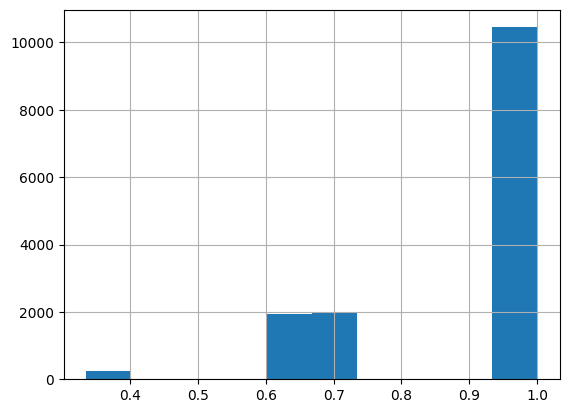

In [154]:
train['airline_sentiment_confidence'].hist()

<Axes: >

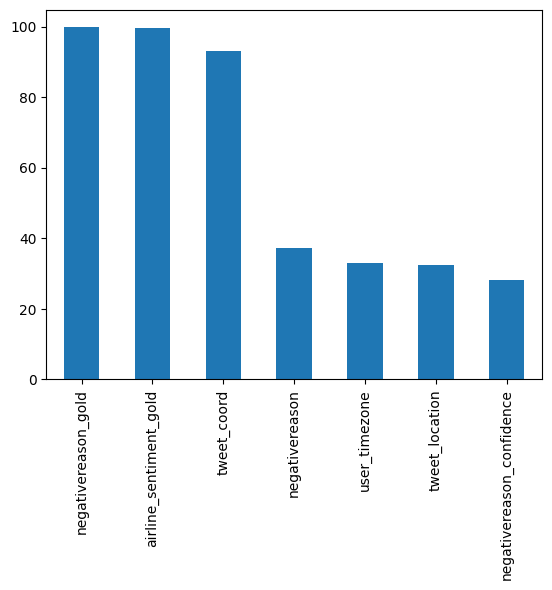

In [155]:
train_all_null=(train.isnull().sum()/len(train))*100
train_null_percent=train_all_null[train_all_null>0].sort_values(ascending=False)
train_null_percent.plot.bar()

In [156]:
train.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [157]:
train=train.drop(['negativereason_gold','airline_sentiment_gold','tweet_coord'],axis=1)

In [158]:
train_all_null=(train.isnull().sum()/len(train))*100
train_null_percent=train_all_null[train_all_null>0].sort_values(ascending=False)

<Axes: xlabel='airline_sentiment', ylabel='count'>

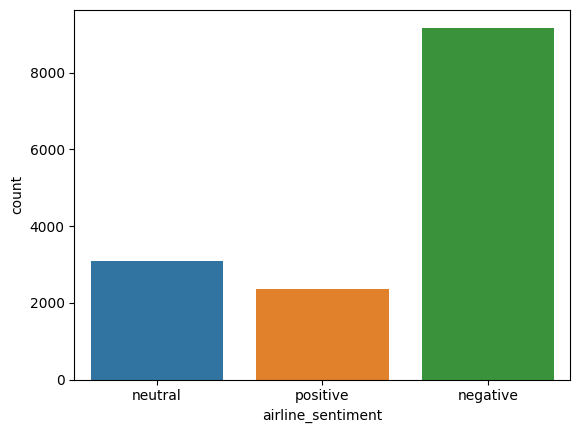

In [159]:
sns.countplot(data=train,x='airline_sentiment')

<Axes: title={'center': 'sentiment for each airline'}, xlabel='airline', ylabel='airline_sentiment_confidence'>

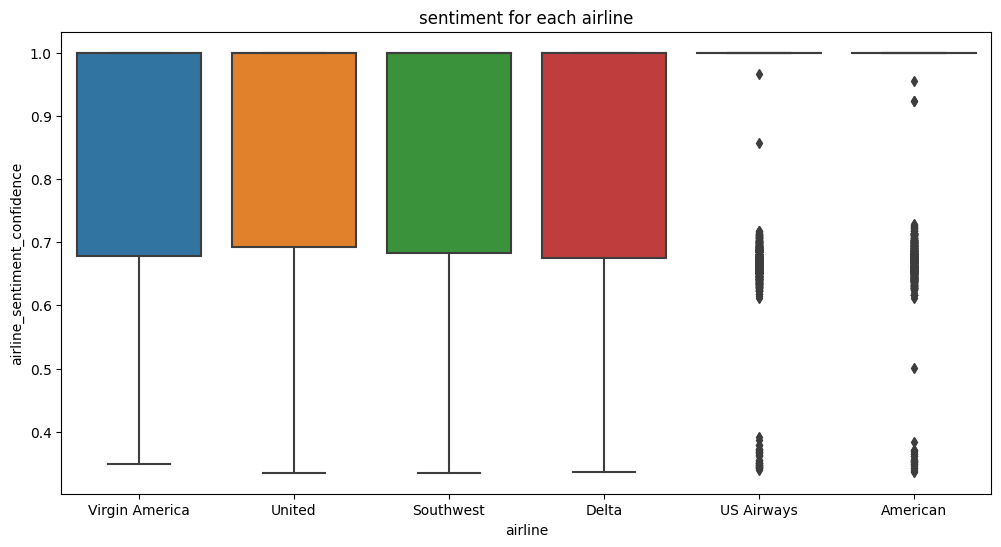

In [160]:
plt.figure(figsize=(12,6))
plt.title('sentiment for each airline')
sns.boxplot(data=train,x='airline',y='airline_sentiment_confidence')

In [161]:
train_null_percent

negativereason               37.308743
user_timezone                32.923497
tweet_location               32.329235
negativereason_confidence    28.128415
dtype: float64

In [162]:
train[['user_timezone','tweet_location']]

,user_timezone,tweet_location
0,Eastern Time (US & Canada),NaN
1,Pacific Time (US & Canada),NaN
2,Central Time (US & Canada),Lets Play
3,Pacific Time (US & Canada),NaN
4,Pacific Time (US & Canada),NaN
...,...,...
14635,NaN,NaN
14636,NaN,Texas
14637,NaN,"Nigeria,lagos"
14638,Eastern Time (US & Canada),New Jersey


In [163]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [164]:
def cleaning(sentence):
    sentence=sentence.lower()
    txt=re.sub('@','',sentence)
    txt=re.sub("'","",txt)
    txt=re.sub(",","",txt)
    txt=re.sub('"',"",txt)
    txt=re.sub('\.',"",txt)
    txt=re.sub(';',"",txt)
    # txt=re.sub("[^&]*&[^&]*","",txt)
    txt=re.sub("#|https?:\/\/\S+","",txt)
    txt=txt.split()[1:]
    return ' '.join(txt)

In [165]:
train['text']=train['text'].apply(cleaning)

In [166]:
stopwords=set(stopwords.words('english'))

In [167]:
def removal_stopwords(tokens):
     return [token.lower() for token in tokens if token.lower() not in set(stopwords)]


In [168]:
train['text']=train['text'].apply(lambda row:word_tokenize(row))

In [169]:
train['text']=train['text'].apply(removal_stopwords)

In [170]:
ps=PorterStemmer()
def stemming(lst):
    stemmed_word=[ps.stem(word) for word in lst]
    return ' '.join(stemmed_word)

In [171]:
train['text']=train['text'].apply(stemming)

In [172]:
len(train)

14640

In [173]:
def reason(sentiment):
    if sentiment=='positive' or sentiment=='neutral':
        return "nothing"
    else:
        return sentiment
def confidence(sentiment):
    if sentiment=='positive' or sentiment=='neutral':
        return 0
    else:
        return sentiment

In [174]:
train['negativereason']=train.groupby('airline_sentiment')['negativereason'].transform(lambda x:x.fillna(reason(x.name)))
train['negativereason_confidence']=train.groupby('airline_sentiment')['negativereason_confidence'].transform(lambda x:x.fillna(confidence(x.name)))

In [175]:
train['negativereason'].isnull().sum()

0

In [176]:
train['negativereason'].value_counts()

negativereason
nothing                        5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

In [177]:
reasons_unique=train['negativereason'].unique()
N=len(reasons_unique)

In [178]:
sentiment_unique=train['airline_sentiment'].unique()
M=len(sentiment_unique)

In [179]:
drop_cols=['tweet_created', 'tweet_location','user_timezone','name','retweet_count']
train.drop(drop_cols,axis=1,inplace=True)

In [180]:
train.select_dtypes(exclude='object').corr()

,tweet_id,airline_sentiment_confidence,negativereason_confidence
tweet_id,1.00000,0.024840,0.063550
airline_sentiment_confidence,0.02484,1.000000,0.380525
negativereason_confidence,0.06355,0.380525,1.000000


In [181]:
le=LabelEncoder()
train['airline_sentiment']=le.fit_transform(train['airline_sentiment'])
train['negativereason']=le.fit_transform(train['negativereason'])

In [182]:
# train['negativereason']=train['negativereason'].apply(lambda x:x.lower())

In [183]:
train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
0,570306133677760513,1,1.0000,10,0.0000,Virgin America,dhepburn said
1,570301130888122368,2,0.3486,10,0.0000,Virgin America,plu youv ad commerci experi tacki
2,570301083672813571,1,0.6837,10,0.0000,Virgin America,didnt today must mean need take anoth trip !
3,570301031407624196,0,1.0000,0,0.7033,Virgin America,realli aggress blast obnoxi entertain guest fa...
4,570300817074462722,0,1.0000,1,1.0000,Virgin America,realli big bad thing


In [184]:
train['airline']=train['airline'].str.lower().str.replace(" ","")

In [185]:
train['text']=train['text']+ ' '+train['airline']

In [186]:
train.drop(['airline'],axis=1,inplace=True)

In [187]:
tokenizer=Tokenizer(10000)
tokenizer.fit_on_texts(train['text'])
sequences=tokenizer.texts_to_sequences(train['text'])

In [188]:
unique_words=tokenizer.word_index
V=len(unique_words)
print(f'We have {V} unique words in the vocabulary')

We have 12359 unique words in the vocabulary


In [189]:
padded_seq=pad_sequences(sequences)

In [190]:
T=padded_seq.shape[1]

In [191]:
# X=train.drop(['airline_sentiment','tweet_id','negativereason','text'],axis=1)
y_sentiment=train['airline_sentiment']
y_reason=train['negativereason']

In [192]:
y_reason.head()

0    10
1    10
2    10
3     0
4     1
Name: negativereason, dtype: int64

In [193]:
# X.shape
padded_seq.shape

(14640, 26)

## Neural Network

In [194]:
i = Input(shape=(T,))
x = Embedding(V+1, 30)(i)
# x = GlobalMaxPooling1D()(x)
x = LSTM(16, activation='tanh', return_sequences=False)(x)  # Ensure return_sequences=False
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
shared_x = Dense(64, activation='relu')(x)

x1 = Dense(M, activation='softmax',name='sentiment')(shared_x)
x2 = Dense(N, activation='softmax',name='reasons')(shared_x)
model=Model(i,[x1,x2])

In [195]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 26)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 26, 30)         │        370,800 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 16)             │          3,008 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16)             │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │          2,176 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 128)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 256)            │         33,024 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 256)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 512)            │        131,584 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 512)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │         32,832 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment (Dense)         │ (None, 3)              │            195 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reasons (Dense)           │ (None, 11)             │            715 │ dense_15[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 574,334 (2.19 MB)

 Trainable params: 574,334 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
model.compile(metrics=['accuracy','accuracy'],
              loss={'sentiment':'sparse_categorical_crossentropy','reasons':'sparse_categorical_crossentropy'},
              optimizer='adam')

In [204]:
r=model.fit(padded_seq,[y_sentiment,y_reason],epochs=50)

Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9661 - reasons_accuracy: 0.7651 - reasons_loss: 0.7511 - sentiment_accuracy: 0.9282 - sentiment_loss: 0.2150
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9010 - reasons_accuracy: 0.7821 - reasons_loss: 0.6999 - sentiment_accuracy: 0.9353 - sentiment_loss: 0.2012
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8203 - reasons_accuracy: 0.8009 - reasons_loss: 0.6417 - sentiment_accuracy: 0.9432 - sentiment_loss: 0.1786
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7908 - reasons_accuracy: 0.8136 - reasons_loss: 0.6096 - sentiment_accuracy: 0.9401 - sentiment_loss: 0.1812
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7527 - reasons_accuracy: 0.8180 - reasons_loss: 0.5929 - sentiment_accuracy: 0.9486 - sentiment_loss: 0.1598
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7257 - reasons_accuracy: 0.8269 - reasons_loss: 0.5645 - sentiment_accuracy: 0.9479

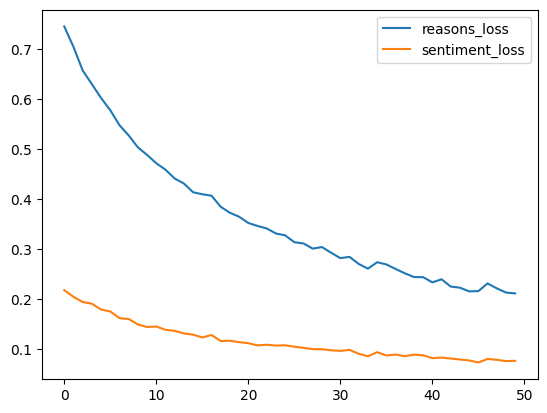

In [205]:
plt.plot(r.history['reasons_loss'],label='reasons_loss')
plt.plot(r.history['sentiment_loss'],label='sentiment_loss')
plt.legend()

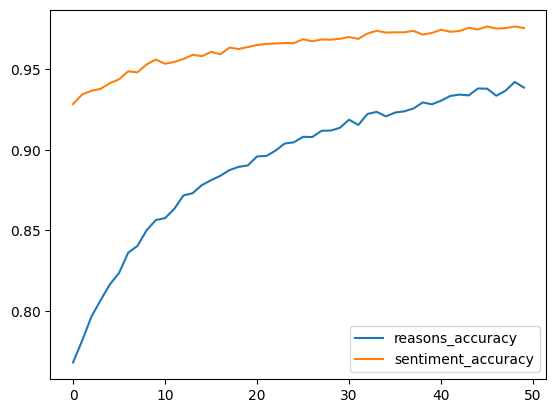

In [206]:
plt.plot(r.history['reasons_accuracy'],label='reasons_accuracy')
plt.plot(r.history['sentiment_accuracy'],label='sentiment_accuracy')
plt.legend()

In [216]:
reason_unique

NameError: name 'reason_unique' is not defined